In [398]:
import celerite2
from celerite2 import driver
import exoplanet as xo

In [457]:
class NSTerm(celerite2.terms.Term):
    
    def __init__(self, term, f):
        self.term = term
        self.f = f
        
    def get_coefficients(self):
        return self.term.get_all_coefficients()
    
    def get_celerite_matrices(self, x, diag, a=None, c=None, U=None, V=None):
        
        c, a, U, V = self.term.get_celerite_matrices(x, np.zeros_like(x))
        farr = np.tile(self.f(x), (np.shape(U)[1], 1)).T
        return c, farr[:, 0] * farr[:, 0] * a + diag, farr * U, farr * V
    
    def __add__(self, b):
        return NSTermSum(self, b)
    
    def __radd__(self, b):
        return NSTermSum(b, self)
    
class NSTermSum(celerite2.terms.Term):
    
    def __init__(self, *terms):
        self._terms = terms
        
    def __add__(self, b):
        return NSTermSum(b, *self._terms)
    
    def __radd__(self, b):
        return NSTermSum(*self._terms, b)
        
    def get_coefficients(self):
        coeffs = (t.get_coefficients() for t in self.terms)
        return tuple(np.concatenate(c) for c in zip(*coeffs))
        
    def get_celerite_matrices(self, x, diag, a=None, c=None, U=None, V=None):
        
        c, a, U, V = self._terms[0].get_celerite_matrices(x, np.zeros_like(x))
        farr = np.tile(self._terms[0].f(x), (np.shape(U)[1], 1)).T
        U = farr * U
        V = farr * V
        a = farr[:, 0] * farr[:, 0] * a
        
        for term in self._terms[1:]:
            
            ct, at, Ut, Vt = term.get_celerite_matrices(x, np.zeros_like(x))
            farr = np.tile(term.f(x), (np.shape(Ut)[1], 1)).T
            a = a + farr[:, 0] * farr[:, 0] * at
            c = np.concatenate((c, ct))
            U = np.concatenate((U, farr * Ut), axis=1)
            V = np.concatenate((V, farr * Vt), axis=1)
                        
        return c, a + diag, U, V

In [894]:
def f(x, sigma, delta, t0):
    
    if abs(x - t0) < 0.5 * delta:
        return 1
    elif x < t0:
        mu = t0 - 0.5 * delta
    else:
        mu = t0 + 0.5 * delta
        
    return np.exp( - 0.5 * (x - mu)**2 / sigma**2 )

f = np.vectorize(f)

In [1020]:
k1 = NSTerm(celerite2.terms.RotationTerm(f=1, Q0=100, dQ=1, period=2, sigma=1), lambda x: f(x, 10, 50, 25))
k2 = NSTerm(celerite2.terms.RotationTerm(f=1, Q0=100, dQ=1, period=3, sigma=1), lambda x: f(x, 10, 50, 75))
#k3 = NSTerm(celerite2.terms.RotationTerm(f=0.5, Q0=10, dQ=2, period=0.65, sigma=1), lambda x: np.exp(-(x+3)**2/8))

t = np.linspace(0, 100, 10000)
%time gp = celerite2.GaussianProcess(k1 + k2, t, diag=0.001)

y = gp.sample()

CPU times: user 64.6 ms, sys: 4.71 ms, total: 69.3 ms
Wall time: 75.2 ms


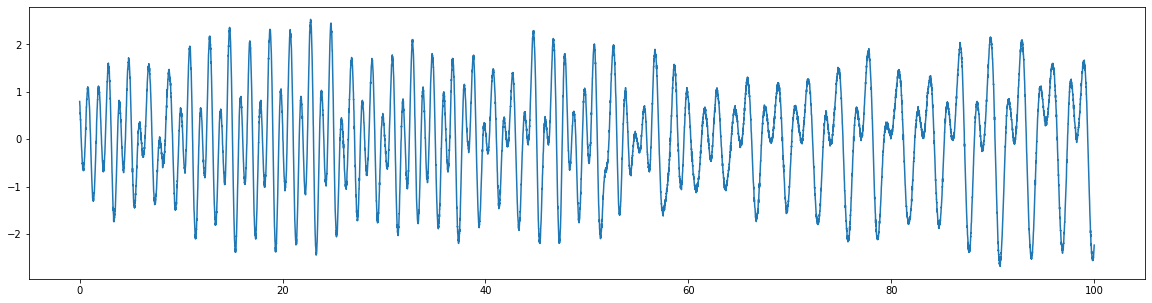

In [1021]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
plt.plot(t, y, '-')

In [1004]:
lag, acf = xo.estimators.autocorr_estimator(t, y)['autocorr']

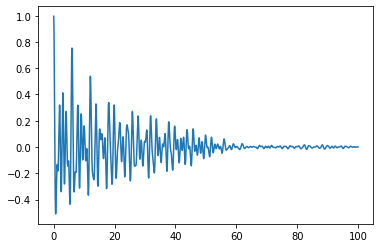

In [1005]:
plt.plot(lag, acf)

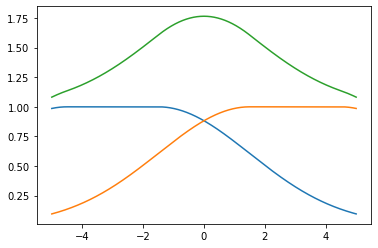

In [944]:
plt.plot(t, f(t, 3, 3, -3))
plt.plot(t, f(t, 3, 3, 3))
plt.plot(t, f(t, 3, 3, 3) + f(t, 3, 3, -3))

In [869]:
f(t, 1, 4, -2)

1